# Data loading

In this notebook we'll show how to use torchvision to handle datasets that are not part of `torchvision.datasets`. Specificially we'll be using the 2011 version of the [CUB200](http://www.vision.caltech.edu/visipedia/CUB-200-2011.html) dataset. This is a dataset with 200 different species of birds. Each species has around 60 images, which are around 500x500 pixels each. Our goal is to correctly determine which species an image belongs to - a 200-dimensional image classification problem.

As this is a relatively small dataset - ~12,000 images compared to CIFAR10's 60,000 images - we'll be using a pre-trained model and then performing transfer learning using discriminative fine-tuning. 

**Note:** on the CUB200 dataset website there is a warning about some of the images in the dataset also appearing in ImageNet, which our pre-trained model was trained on. If any of those images are in our test set then this would be a form of "information leakage" as we are evaluating our model on images it has been trained on. However, the GitHub gist linked at the end of [this](https://guopei.github.io/2016/Overlap-Between-Imagenet-And-CUB/) article states that only 43 of the images appear in ImageNet. Even if they all ended up in the test set this would only be ~1% of all images in there so would have a negligible impact on performance.

### Data Processing

As always, we'll start by importing all the necessary modules.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from torch.utils.data import Dataset

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

import copy
from collections import namedtuple
import os
import random
import shutil
import time

import cv2

Next, we'll set the random seeds for reproducability.

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

We'll be using our own dataset instead of using one provided by `torchvision.datasets`.

The url of the CUB200-2011 dataset can be found on its [website](http://www.vision.caltech.edu/visipedia/CUB-200-2011.html). However, the dataset is now hosted on Google Drive which has problems with files exceeding their download quota. 

Instead, we'll download the dataset from [Kaggle](https://www.kaggle.com) using the [kaggle-api](https://github.com/Kaggle/kaggle-api) which needs to be installed with `pip install kaggle`.

First, we need to have a Kaggle account in order to generate an API key. Once we're logged on to Kaggle, we need to go to `https://www.kaggle.com/<username>/account` and click `Create New API Token` in the API section which will download a `kaggle.json` file. Place this at `~/.kaggle/kaggle.json` (or, if you're on Windows, at `C:\Users\<Windows-username>\.kaggle\kaggle.json`). 

If we are using Google Colab, an alternative is simply set the environment variables `KAGGLE_USERNAME` and `KAGGLE_KEY` to their respective values. This is what we do below.

Next, we'll download the dataset from where it is hosted on Kaggle, at: https://www.kaggle.com/veeralakrishna/200-bird-species-with-11788-images. This is done with `!kaggle datasets download <kaggle-url> --unzip`, where the `<kaggle-url>` is the dataset URL after the `kaggle.com` part, which is `veeralakrishna/200-bird-species-with-11788-images` for this dataset.

[`datasets.utils`](https://github.com/pytorch/vision/blob/master/torchvision/datasets/utils.py) contains some functionality for downloading and extract data which means we don't have to write it ourselves.

We use the `extract_archive` function, which extracts a file to a given root folder. We should now have a `data/CUB_200_2011` folder which contains our entire dataset.

In [3]:
# REPLACE THESE WITH YOUR OWN KAGGLE USERNAME AND KEY
#os.environ['KAGGLE_USERNAME'] = 'YOUR_KAGGLE_USERNAME_HERE'
#os.environ['KAGGLE_KEY'] = 'YOUR_KAGGLE_KEY_HERE'

os.environ['KAGGLE_USERNAME'] = 'nagda9'
os.environ['KAGGLE_KEY'] = '417afeaf7fe66a09b3f885d9e45e1fb5'

!pip install kaggle
!kaggle datasets download veeralakrishna/200-bird-species-with-11788-images --unzip

ROOT = 'data'

datasets.utils.extract_archive('CUB_200_2011.tgz', ROOT)

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 58 kB 3.3 MB/s             
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 76 kB 3.0 MB/s             
     |████████████████████████████████| 78 kB 3.1 MB/s            
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73994 sha256=b579879d6c52e629e09c3195beab6246d2c59580763851278bb0b91f1b70be3b
  Stored in directory: /home/dani/.cache/pip/wheels/77/47/e4/44a4ba1b7dfd53faaa35f59f1175e123b213ff401a8a56876b
Successfully built kaggle
100%|██████████████████████████████████████| 1.11G/1.11G [01:12<00:00, 13.2MB/s]
100%|██████████████████████████████████████| 1.11G/1.11G [01:12<00:00, 16.4MB/s]


'data'

To handle using custom datasets, torchvision provides a [`datasets.ImageFolder`](https://pytorch.org/docs/stable/torchvision/datasets.html#torchvision.datasets.ImageFolder) class. 

`ImageFolder` expects data to be stored in the following way:

```
root/class_x/xxy.png
root/class_x/xxz.jpg

root/class_y/123.jpeg
root/class_y/nsdf3.png
root/class_y/asd932_.jpg
```

That is, each folder in the root directory is the name of a class, and within each of those folders are the images that correspond to that class. The images in the downloaded dataset are currently in the form of:

```
CUB_200_2011/images/class_a/image_1.jpg
CUB_200_2011/images/class_a/image_2.jpg

CUB_200_2011/images/class_b/image_1.jpg
CUB_200_2011/images/class_b/image_2.jpg

CUB_200_2011/images/class_c/image_1.jpg
CUB_200_2011/images/class_c/image_2.jpg
```

This means we could call `datasets.ImageFolder(root = '.data/CUB_200_2011/images)` and it would load all of the data. However, we want to split our data into train and test splits. This could be done with `data.random_split`, which we have used in the past to create our validation sets - but we will show how to manually create a `train` and `test` folder and store the relevant images in those folders. This way means that we only need to create a train/test split once and re-use it each time we re-run the notebook

We first set a `TRAIN_RATIO` which will decide what percentage of the images per class are used to make up the training set, with the remainder making up the test set. We create a `train` and `test` folder within the `CUB_200_2011` folder - after first deleting them if they already exist. Then, we get a list of all classes and loop through each class. For each class we get the image names, use the first `TRAIN_RATIO` of them for the training set and the remainder for the test set. We then copy - with `shutil.copyfile` - each of the images into their respective `train` or `test` folder. It is usually better to copy, rather than move, the images to create your custom splits just in case we accidentally mess up somewhere.

After running the below cell we have our training set as:

```
CUB_200_2011/images/train/class_a/image_1.jpg
CUB_200_2011/images/train/class_a/image_2.jpg

CUB_200_2011/images/train/class_b/image_1.jpg
CUB_200_2011/images/train/class_b/image_2.jpg

CUB_200_2011/images/train/class_b/image_1.jpg
CUB_200_2011/images/train/class_b/image_2.jpg
```

and our test set as:

```
CUB_200_2011/images/test/class_a/image_48.jpg
CUB_200_2011/images/test/class_a/image_49.jpg

CUB_200_2011/images/test/class_b/image_48.jpg
CUB_200_2011/images/test/class_b/image_49.jpg

CUB_200_2011/images/test/class_c/image_48.jpg
CUB_200_2011/images/test/class_c/image_49.jpg
```

This train/test split only needs to be created once and does not need to be created again on subsequent runs.

**Note:** `ImageFolder` will only load files that have image related extensions, i.e. jpg/jpeg/png, so if there was, for example, a `.txt` file in one of the class folders then it would not be loaded with the images. If we wanted more flexibility when deciding which files to load or not - such as not loading .png images or loading images with an esoteric format - then we could either use the `is_valid_file` argument of the `ImageFolder` class or use [`DatasetFolder`](https://pytorch.org/docs/stable/torchvision/datasets.html#torchvision.datasets.DatasetFolder) and provide a list of valid extensions to the `extensions` argument.

In [4]:
TRAIN_RATIO = 0.8

data_dir = os.path.join(ROOT, 'CUB_200_2011')
images_dir = os.path.join(data_dir, 'images')
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

if os.path.exists(train_dir):
    shutil.rmtree(train_dir) 
if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
    
os.makedirs(train_dir)
os.makedirs(test_dir)

classes = os.listdir(images_dir)

for c in classes:
    
    class_dir = os.path.join(images_dir, c)
    
    images = os.listdir(class_dir)
       
    n_train = int(len(images) * TRAIN_RATIO)
    
    train_images = images[:n_train]
    test_images = images[n_train:]
    
    os.makedirs(os.path.join(train_dir, c), exist_ok = True)
    os.makedirs(os.path.join(test_dir, c), exist_ok = True)
    
    for image in train_images:
        image_src = os.path.join(class_dir, image)
        image_dst = os.path.join(train_dir, c, image) 
        shutil.copyfile(image_src, image_dst)
        
    for image in test_images:
        image_src = os.path.join(class_dir, image)
        image_dst = os.path.join(test_dir, c, image) 
        shutil.copyfile(image_src, image_dst)

Now we've got our train/test splits we can go ahead and calculate the mean and standard deviation (std) of our dataset to normalize it. We're actually going to use a pre-trained model in this notebook so will be using the mean and std desired by the pre-trained data, so we don't actually have to calculate this - however it is left as an example.

Calculating the mean and std is slightly different than when using a dataset provided by torchvision as those datasets have all of the images stored as numpy arrays in the data's `data` attribute, whilst datasets loaded by `ImageFolder` and `DataFolder` do not.

First, we load the `train_data` from the `train` folder. Remember: the mean and std must only be calculated from the training data. This will load PIL images by default so we pass the `ToTensor` transform which converts all the PIL images to tensors and scales them from 0-255 to 0-1.

We then loop through each image and calculate the mean and std across the height and width dimensions with `dim = (1,2)`, summing all the means and stds and then finding the average by dividing them by the number of examples, `len(train_data)`.

Again, this only needs to be calculated once per dataset and the means and stds calculated here can be re-used without calculating them for other runs. The exception to this is if we used a different train/test split, then we would need to calculate these again.

In [5]:
train_data = datasets.ImageFolder(root = train_dir, 
                                  transform = transforms.ToTensor())

means = torch.zeros(3)
stds = torch.zeros(3)

for img, label in train_data:
    means += torch.mean(img, dim = (1,2))
    stds += torch.std(img, dim = (1,2))

means /= len(train_data)
stds /= len(train_data)
    
print(f'Calculated means: {means}')
print(f'Calculated stds: {stds}')

Calculated means: tensor([0.4864, 0.5002, 0.4320])
Calculated stds: tensor([0.1820, 0.1810, 0.1928])


# Defining custom data set

In [8]:
class challange_dataset(Dataset):
  def __init__(self, data_path, transforms=None):
    self.data_path = data_path
    self.nbr_samples = 0
    self.transforms = transforms

    # TODO: a mappakbol a kepek egyertelmu indexelése
    self.image_paths = []
    for class_folder in os.listdir(self.data_path):
      if not os.path.isdir(class_folder):
        continue
      for image_name in os.listdir(os.path.join(data_path, class_folder)):
        self.image_paths.append(os.path.join(data_path, class_folder, image_name))
      


  def __len__(self):
    return len(self.image_paths)
    
  def __getitem__(self, idx):
    # TODO: index alapjan visszaadni a kepet
    image_path = self.image_paths[idx]
    image = cv2.imread(image_path)

    if (self.transforms):
      image = self.transforms(image)

    label = int(os.path.dirname(image_path)[:4])
    
    return image, label

In [10]:
dataset = challange_dataset("data/CUB_200_2011/images")

# NOTE! AlexNet es VGG transfer learning ajanlott. Fontos, hogy ezeknel a normalizalast a sajat tanulohalmazuk alapjan kell csinalni. 
# NOTE! validacio es train halmaz szetvalasztasakor figyelni kell, hogy a szetvalasztani kivant halmaz meg legyen keverve
# NOTE! validacion es test halmazon nem augmentalunk
# NOTE! augmentacio kell az overfitting elkerulesere, de csak olyan hasznalhato, ami nem rombolja az adatot
# NOTE! transfer learningnel tapasztalat szerint erdemes az osszes sulyt updatelni, nem freezelni
# NOTE! batch normalizacio: bizonyos retegek utan visszaallitjuk a normalizaltsagot, mivel egy ido utan elakadhatnak a sulyok
# NOTE! learning rate-tel erdemes varialni: uj halo tanitas eseten 0.01 jo kiindulas, pretrained eseten 0.00001 (10e-5)
# NOTE! regresszio jobb lehet, mert tobb visszajelzest ad a halonak, de klasszifikacioval talan gyorsabb elerni eredmenyt
# NOTE! ha a validacios ertek elkezd letörni, akkor overfitting van -> tobb augmentacio, dropout
# NOTE! utana nezni meg tippeknek neten

# Creating data transforms

Now to actually load our data. As we are going to be using a pre-trained model we will need to ensure that our images are the same size and have the same normalization as those used to train the model - which we find on the torchvision [models](https://pytorch.org/docs/stable/torchvision/models.html) page.

There's a few things we need to consider in regards to data processing when using pre-trained models.

As mentioned in the torchvision models [page](https://pytorch.org/docs/stable/torchvision/models.html):

> All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].

Thus, we need to resize our 32x32 images to 224x224 and also normalize them with the given means and stds instead of calculating them from the CIFAR10 dataset.

Even though the VGG models can handle images as small as 32x32 and convolutional layers are translation invariant, our images still need to be resized as the pre-trained `classifier` layer is expecting certain features to appear in certain places within the flattened 512x7x7 output of the `features` layer after the adaptive average pooling. Using a different image size than was used to pre-train the model causes features sent to the `classifier` to be in different places than expected, and thus leads to poor performance when using the pre-trained model.

We need to use the same means and stds to make the colors of the images fed to the model with the pre-trained parameters be the same as they were to train the pre-trained model. Let's say the original dataset had lots of dark green images and the mean for the green channel was be relatively low, say 0.2, and the dataset we are going to use had lots of light green images with the mean for the green channel being around 0.8. The pre-trained model was trained with dark green pixels normalized to zero (subtracting the mean). If we incorrectly used the means and stds from our dataset we want to apply our model on, then light green pixels will be normalized to zero, thus our pre-trained model will think a given light green image is actually a dark green image. This will confuse our model and lead to poor performance.

We handle the resizing with the `Resize` transform, passing in the desired size. As the images are larger we can also get away with slightly higher rotations and crops within the `RandomRotation` and `RandomCrop` transforms. We pass the pre-trained mean and stds the same way we would pass our calculated means and transforms.

In [11]:
pretrained_size = 224
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds= [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(pretrained_size, padding = 10),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.CenterCrop(pretrained_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

# Creating data set

We load our data with our transforms...

In [12]:
train_data = datasets.ImageFolder(root = train_dir, 
                                  transform = train_transforms)

test_data = datasets.ImageFolder(root = test_dir, 
                                 transform = test_transforms)

...create the validation split...

In [13]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data, 
                                           [n_train_examples, n_valid_examples])

...and then overwrite the validation transforms, making sure to do a `deepcopy` to stop this also changing the training data transforms.

In [14]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

To make sure nothing has messed up we'll print the number of examples in each of the data splits - ensuring they add up to the number of examples indicated on the [CUB200-2011 dataset website](http://www.vision.caltech.edu/visipedia/CUB-200-2011.html) (11,788).

In [15]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 8472
Number of validation examples: 942
Number of testing examples: 2374


Next, we'll create the iterators with the largest batch size that fits on our GPU. 

In [16]:
BATCH_SIZE = 64

train_iterator = data.DataLoader(train_data, 
                                 shuffle = True, 
                                 batch_size = BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data, 
                                 batch_size = BATCH_SIZE)

test_iterator = data.DataLoader(test_data, 
                                batch_size = BATCH_SIZE)

To ensure the images have been processed correctly we can plot a few of them - ensuring we re-normalize the images so their colors look right.

In [17]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image    

In [18]:
def plot_images(images, labels, classes, normalize = True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (15, 15))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        label = classes[labels[i]]
        ax.set_title(label)
        ax.axis('off')

We can see the images look fine, however the names of the classes provided by the folders containing the images are a little long and sometimes overlap with neighbouring images.

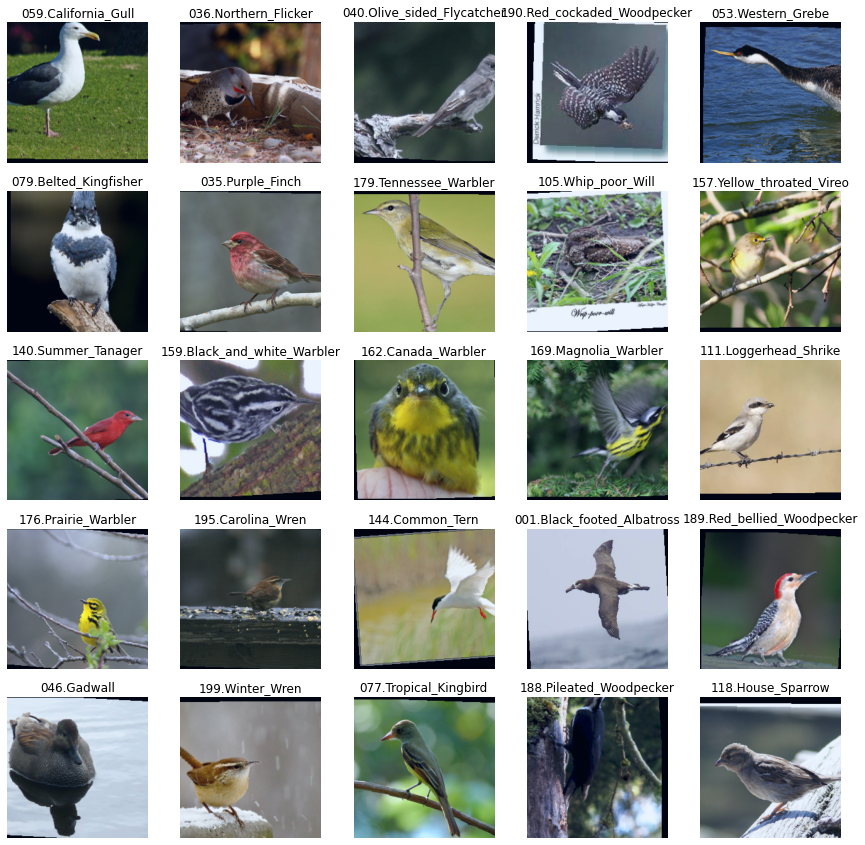

In [19]:
N_IMAGES = 25

images, labels = zip(*[(image, label) for image, label in 
                           [train_data[i] for i in range(N_IMAGES)]])

classes = test_data.classes

plot_images(images, labels, classes)

One way to solve the issue with the names of the classes would have been to manually change the names of the folders before we copied them over into the `train` and `test` folders. 

Another approach is to directly change the names of each class provided by the dataset's `.classes`. We'll make a `format_label` function which will strip off the number at the start of each class and convert them into title case.

In [20]:
def format_label(label):
    label = label.split('.')[-1]
    label = label.replace('_', ' ')
    label = label.title()
    label = label.replace(' ', '')
    return label

Let's change the class names and re-plot the images with their new class names.

No more overlapping!

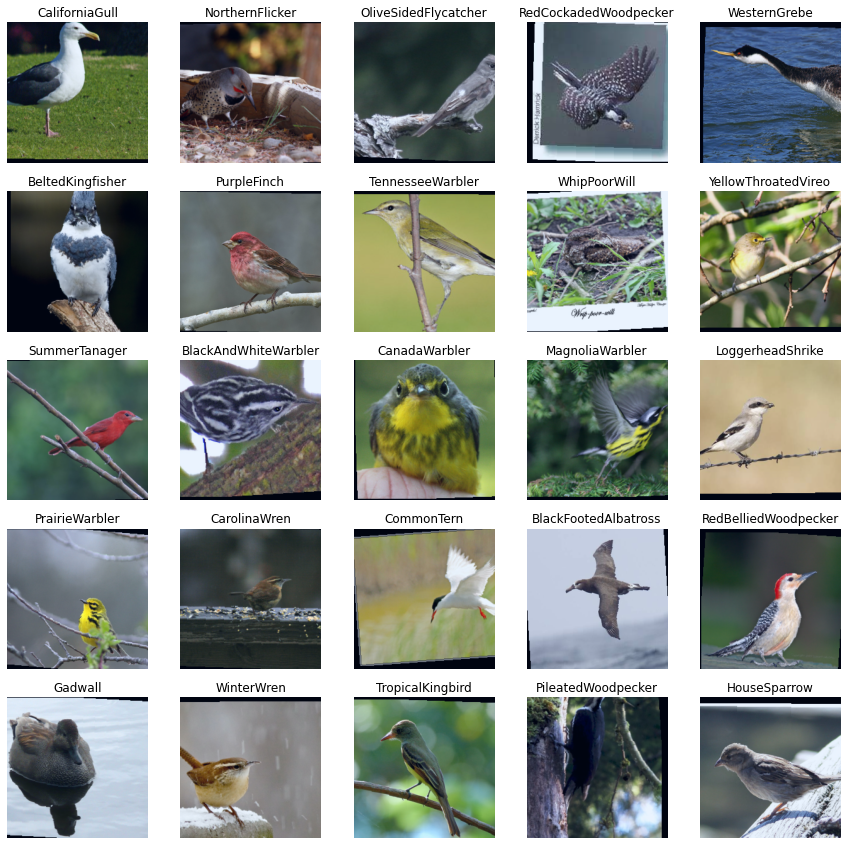

In [21]:
test_data.classes = [format_label(c) for c in test_data.classes]

classes = test_data.classes

plot_images(images, labels, classes)

#  VGG model

In this notebook we will be implementing one of the [VGG](https://arxiv.org/abs/1409.1556) model variants. VGG is a neural network model that uses convolutional neural network (CNN) layers and was designed for the [ImageNet challenge](http://www.image-net.org/challenges/LSVRC/), which it won in 2014.

VGG is not a single model, but a family of models that are all similar but have different *configurations*. Each configuration specifies the number of layers and the size of each layer. The configurations are listed in table 1 of the [VGG paper](https://arxiv.org/pdf/1409.1556.pdf) and denoted by a letter, although recently they are just referred to as the number of layers with weights in the model, e.g. configuration "A" has 11 layers with weights so is known as VGG11.

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/vgg-table.png?raw=1)

Below is the architecture of configuration "D", also known as VGG16, for a 224x224 color image.

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/vgg.png?raw=1)

The other commonly used VGG variants are VGG11, VGG13 and VGG19, which correspond to configurations "A", "B", and "E". Configurations "A-LRN" and "C" - which is the same as "D" but with smaller filter sizes in some convolutional layers - are rarely used.

In this notebook, we will use the 2011 version of the [CUB200](http://www.vision.caltech.edu/visipedia/CUB-200-2011.html) dataset. However we will be making use of *pre-trained* models. 

Usually we will initialize our weights randomly - following some weight initialization scheme - and then train our model. Using a pre-trained model means some - potentially all - of our model's weights are not initialized randomly, but instead taken from a copy of our model that has already been trained on some task. The task the model has been pre-trained on does not necessarily have to match the "downstream task" - the task we want to use the pre-trained model on. For example, a model that has been trained to classify images can then be used to detect objects within an image.

The theory is that these pre-trained models have already learned high level features within images that will be useful for our task. This means we don't have to learn them from scratch when using the pre-trained model for our task, causing our model to converge earlier. We can also think of the pre-trained model as being a very good set of weights to initialize our model from, and using pre-trained models usually leads to a performance improvement compared to initializing our weights randomly. 

The act of using a pre-trained model is generally known as *transfer learning*, as we are learning to transfer knowledge from one task to another. It is also referred to as *fine-tuning*, as we fine-tune our parameters trained on one task to the new, downstream task. The terms *transfer learning* and *fine-tuning* are used interchangably in machine learning. 

We are also going to look into a technique called [discriminative fine-tuning](https://arxiv.org/abs/1801.06146), initially introduced to improve transfer learning for text classification but has been used for computer vision tasks too. 

### Data Processing

As always, we'll import the modules we need. No new imports yet.

### Defining the Model

Usually the next thing we'd do is load our data, however this is quite different when using a pre-trained model, so we'll first introduce the VGG architecture and then show how to load a pre-trained VGG model.

Below is the general VGG model. This is the part of VGG that is common for all VGG configurations. The only part that depends the configuration is the `features`, which we will pass as an argument when we construct the VGG model.

The only new feature introduced here in the `AdaptiveAvgPool2d`. As well as the standard `AvgPool` and `MaxPool` layers, PyTorch has "adaptive" versions of those layers. In adaptive pooling layers we specify the desired output size of the pooling layer instead of the size of the filter used by the pooling layer. Here, we want an output size of 7x7. We know that all VGG configurations end with a convolutional layer that has 512 filters, thus if our `features` layer for each configuration always has a size of 7x7 we do not have to change the `classifier` for each VGG configuration. The advantage of using adaptive layers is that it allows us to apply our model to images of different sizes - down to a minimum size, which is 32x32 in VGG models.

**Note:** even though VGG net can handle images as small as 32x32 it is designed to give optimal performance for larger images. We handle this later on in this practice.

How do the adaptive pooling layers calculate the size of their filters? For each dimension, i.e. height and width, we calculate:

```
filter_size = (input_size + desired_size - 1) // desired_size
```

`//` means we round down to the nearest integer. So, if we wanted to filter a 32x32 image to 7x7 we would have a 6x6 filter. When the filter is applied to the image it will need to overlap at some points, i.e. some pixels will be covered by the filter twice.

Let's define the VGG base architecture. 

In [22]:
class VGG(nn.Module):
    def __init__(self, features, output_dim):
        super().__init__()
        
        self.features = features

        features[0] = nn.Conv2d(1, 64, 3, 1)
        

        self.avgpool = nn.AdaptiveAvgPool2d(7)
        
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace = True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace = True),
            nn.Dropout(0.5),
            nn.Linear(4096, output_dim),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h

Next up is calculating the `features` for each VGG configuration.

Typically the VGG configurations are defined as lists. Each item in the list is either 'M', which denotes a max pooling layer, or an integer, which denotes a convolutional layer with that many filters.

Below are the configurations for VGG11, VGG13, VGG16 and VGG19. Otherwise known as configurations "A", "B", "D" and "E", respectively.

In [23]:
vgg11_config = [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

vgg13_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

vgg16_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 
                512, 'M']

vgg19_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 
                512, 512, 512, 512, 'M']

We can now define a function which takes in a configuration list and returns a `nn.Sequential` with the respective layers.

`get_vgg_layers` iterates over the configuration list and appends each layer to `layers`, then it converts them to a `nn.Sequential` as it returns. 

We can see that we always use the same size filter (2x2) and stride (2) in all of our max pool layers. As mentioned before, the default stride for pooling layers is equal to the kernel size.

For the convolutional layers we always the same filter size (3x3) and padding (1). As a reminder, padding adds `padding` pixels with values of zero around each side of the image in each channel before the filter is applied. Each convolutional layer is followed by a ReLU non-linearity. We then set the `in_channels` to be equal to the number of filters in the convolutional layer so the next convolutional layer has the correct `in_channels`.

Another new layer introduced here is [batch normalization](https://arxiv.org/abs/1502.03167) (BN) defined with `BatchNorm2d` and only used if `batch_norm = True`. Normalization is when we try to ensure that some data has a mean of zero and a standard deviation (std) of one as this improves learning - both stability and convergence speed - in machine learning models. Previously we have normalized our input data using PyTorch transforms and tried to ensure our data remains as normalized as possible by using weight initialization schemes - such as Glorot or Kaiming. However, as our model begins to train and the parameters change then the mean and std output by each layer will also change. A change in mean and std of the output of one layer will cause a change in mean and std for all following layers. Our model has no way to correct these changes in means and stds once training has begun.

BN is a layer with learnable parameters - two per filter - denoted $\gamma$ and $\beta$. The layer normalizes, scales and then shifts across the channel dimension of the input. The output of a BN layer is calculated by:

$$
\begin{align}
\mu_\mathcal{B} &= \frac{1}{m}\sum^m_{i=1} x_i\\
\sigma^2_\mathcal{B} &= \frac{1}{m}\sum^m_{i=1}(x_i-\mu_\mathcal{B})^2\\
\hat{x}_i &= \frac{x_i - \mu_\mathcal{B}}{\sqrt{\sigma^2_\mathcal{B} + \epsilon}}\\
y_i &= \gamma \hat{x}_i + \beta = \text{BN}_{\gamma,\beta}(x_i) 
\end{align}
$$

The batch $\mathcal{B}$ has $m$ examples, $x_i,\dots,x_m$. We first calculate the mean and variance across each channel dimension of the batch, $\mu_\mathcal{B}$ and $\sigma^2_\mathcal{B}$. Then normalize the batch by subtracting the channel means and dividing by the channel stds (the square root of the variance plus a small epsilon term to avoid division by zero) across each channel. We then scale and shift each channel of this normalized batch of inputs, $\hat{x}_i$ using $\gamma$ and $\beta$.

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/batch-norm.png?raw=1)

Why do we scale and shift? Why not leave the outputs with a mean of zero and a std of one? Perhaps there is a better mean and std for our task instead of zero and one. If this is the case then our model can learn this whilst training as $\gamma$ and $\beta$ are learnable parameters. However, to bias our model to start off with the idea that a mean of zero and a std of one is a good idea by default $\gamma$ and $\beta$ are initialized to one and zero.

There are a few things to consider with batch normalization during inference time (validation or testing). The first is that we don't want to calculate the mean and variance of our data to normalize it during inference. This is because an image in the validation or test set might be drastically different to an image in the training set, and we do not want to remove that information via normalization. The second is what to do with a batch size of one, common when deploying models. Calculating the mean and variance across a single example (a batch size of one) doesn't make sense. 

Luckily, there is a solution to both these problems. Instead of using the actual mean and variance of a batch, we use an exponentially weighted moving average which we update every batch. Then, when using inference (with any batch size, including one) we use the saved weighted average of the means and variances. 

[This](https://www.youtube.com/watch?v=HR0lt1hlR6U&t=5900) video has a good explanation of batch normalization and other types of normalization layers. For another explanation on why batch normalization helps, check out [this](https://arxiv.org/abs/1805.11604) paper.

One last thing to mention on batch normalization is that, in theory, it should be used **after** the activation function. Why would you normalize the output of a layer only to just ruin the normalization effect with an activation function? However, in the original VGG architecture they use batch normalization before the activation function, so we do too. 

In [25]:
def get_vgg_layers(config, batch_norm):
    
    layers = []
    in_channels = 3
    
    for c in config:
        assert c == 'M' or isinstance(c, int)
        if c == 'M':
            layers += [nn.MaxPool2d(kernel_size = 2)]
        else:
            conv2d = nn.Conv2d(in_channels, c, kernel_size = 3, padding = 1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(c), nn.ReLU(inplace = True)]
            else:
                layers += [conv2d, nn.ReLU(inplace = True)]
            in_channels = c
            
    return nn.Sequential(*layers)

Now, let's get the `features` for the VGG11 architecture, with batch normalization.

The original VGG paper did not use batch normalization, but it is now common to use it in VGG models.

In [26]:
vgg11_layers = get_vgg_layers(vgg11_config, batch_norm = True)

We can print them out and ensure they are the same as the "A" configuration of the VGG configuration table.

In [27]:
print(vgg11_layers)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU(inplace=True)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU(inplace=True)
  (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ReLU(inplace=True)
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

We can then pass these `features` to our base VGG module to get our VGG11 model.

In [28]:
OUTPUT_DIM = 200

model = VGG(vgg11_layers, OUTPUT_DIM)

print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, str

### Pre-trained Models

In this notebook we aren't actually going to use a VGG model with parameters that have been randomly initialized VGG model. We are going to be using a VGG model with *pre-trained* parameters. Using a pre-trained model involves initializing our model with parameters that have already been trained for a certain task - usually not the exact same task we are trying to do ourselves.

Torchvision has ways to easily download a pre-trained model. We simply import the `torchvision.models` package, specify which model we want to use and then pass the argument `pretrained = True`. We can see a list of all available pre-trained models provided by torchvision [here](https://pytorch.org/docs/stable/torchvision/models.html). 

Let's import a pre-trained VGG11 with batch normalization. The first time this code is run the pre-trained parameters will be downloaded and are around 140MB for VGG11 with batch normalization.

In [29]:
import torchvision.models as models

pretrained_model = models.vgg11_bn(pretrained = True)

print(pretrained_model)

Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /home/dani/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth
51.7%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

58.8%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

66.2%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub

As we can see, the pre-trained model loaded is exactly the same as the one we have defined with one exception - the output of the final linear layer. 

All of torchvision's pre-trained models are trained as image classification models on the [ImageNet](http://www.image-net.org/challenges/LSVRC/) dataset. A dataset of 224x224 color images with 1000 classes, therefore the final layer will have a 1000 dimensional output.

We can get the last layer specifically by indexing into the `classifier` layer of the pre-trained model.

In [ ]:
pretrained_model.classifier[-1]

Linear(in_features=4096, out_features=1000, bias=True)

As our dataset, CUB200, only has 200 classes then we want the last layer to have a 200 dimensional output. 

We'll define a new final linear layer which has to have an input size equal to that of the layer we are replacing - as it's input will be the 4096 dimensional output from the previous linear layer in the classifier. The output of this linear layer will be 200 dimensions - as our dataset has 200 classes.

In [ ]:
IN_FEATURES = pretrained_model.classifier[-1].in_features 

final_fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)

We can directly overwrite the previous linear layer with our new linear layer. 

Note that our `final_fc` will be initialized randomly. It is the only part of our model with its parameters not pre-trained.

In [ ]:
pretrained_model.classifier[-1] = final_fc

We can then print out the `classifier` of our model to ensure the final linear layer now has an output dimension of 10.

In [ ]:
print(pretrained_model.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=200, bias=True)
)


We could go ahead and use the `pretrained_model` module from here on out, however it only returns the final output layer and not the intermediate representation as our `model` does. We can see that in the model's definition [here](https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py#L47). 

We can load the parameters of the `pretrained_model` into our `model` by loading the parameters (`state_dict`) from the `pretrained_model` into our `model` in the same way we loaded the "best" saved parameters in the previous notebooks - by using `load_state_dict`. However, this time we load directly from the `pretrained_model` instead of using `torch.load` on the path of the saved model parameters. 

This is only possible as our `model` has the exact same layers (order and shape) as the `pretrained_model` with the final linear layer replaced with our 10 dimensional output linear layer.

In [ ]:
model.load_state_dict(pretrained_model.state_dict())

<All keys matched successfully>

This model has considerably big number of parameters than the previous model, AlexNet - 128M compared to 23M.

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 129,591,240 trainable parameters


Instead of training all of the parameters we have loaded from a pre-trained model, we could instead only learn some of them and leave some "frozen" at their pre-trained values. As our model will then have less trainable parameters it will usually train faster and we can usually fit it on smaller GPUs. 

We aren't going to freeze any parameters in this notebook, but if we wanted to freeze the `features` layer then we could do that with:

```python
for parameter in model.features.parameters():
    parameter.requires_grad = False
```

We could also freeze the `classifier` layer, however we always want to train the last layer as this is what we have initialized randomly and needs to be trained. Freezing all but the last layer in the `classifier` can be done with:

```python
for parameter in model.classifier[:-1].parameters():
    parameter.requires_grad = False
```

### Training the Model

Generally when using a pre-trained model the learning rate used will be considerably lower.

First, we'll set up the optimizer with the initial learning rate that is much lower than we expect to use. Then we define the `device` to place our model on our GPU, if we have one. Next we define the `criterion` (loss function) and place the model and criterion on our device.

In [ ]:
LR = 1e-3

optimizer = optim.Adam(model.parameters(), lr = LR)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

We can now create an optimizer with our intial learning rate and using discriminative fine-tuning. 

The concept behind descriminative fine-tuning is that we use different learning rates for different layers in our models. The hypothesis is that early layers in a neural network learn to extract more general features, whilst later layers learn to extract more task specific features. If this is true, then the general features extracted by the early layers should be useful for any task, and we should change the pre-trained weights of them by a very small amount - if at all. 

**Note:** discriminative fine-tuning should only be used when performing transfer learning from a pre-trained model. It is typically not necessary to use it when training a model from randomly initialized weights. 

PyTorch allows us to set different learning rate values per parameter in our model. This is done by passing a list of dictionaries to the optimizer. Each dictionary should state the parameters (`'params'`) and also any other arguments that will override those given directly to the optimizer. 

Here, instead of using a different learning rate for every single layer, we have split the parameters into two "groups": `features`, which contains all of the convolutional layers; and `classifier`, which contains all of the linear layers. `classifier` will be using the `LR` given directly to the optimizer and `features` will be using `LR / 10`, as specified in the first dictionary. Thus, our convolutional layers have a learning rate 10x less than the linear layers.

In [ ]:
params = [
          {'params': model.features.parameters(), 'lr': LR / 10},
          {'params': model.classifier.parameters()}
         ]

optimizer = optim.Adam(params, lr = LR)

Now all of the set-up is done, the rest of the notebook is pretty standard from here on out.

We create a function to calculate accuracy...

In [ ]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

...create a function that implements a training loop...

In [ ]:
def train(model, iterator, optimizer, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred, _ = model(x)
        
        loss = criterion(y_pred, y)
        
        acc = calculate_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

...create a function that performs an evaluation loop...

In [ ]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

...and a helper function to tell us how long an epoch takes.

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Finally, we train our model.

As our images have been resized to be significantly larger and our model has significantly more parameters training takes considerably longer. However, when performing transfer learning we usually train for significantly less epochs and are still able to achieve much higher accuracy than before.

In [ ]:
EPOCHS = 5

best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    
    start_time = time.monotonic()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut4-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

In [ ]:
model.load_state_dict(torch.load('tut4-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

# **This is an optional part which only serve as a reference for your future work**

We'll examin the model now. First, we'll get the predictions for each of the examples in the test set...

In [ ]:
def get_predictions(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [ ]:
images, labels, probs = get_predictions(model, test_iterator)

...then get the predicted labels for each image...

In [ ]:
pred_labels = torch.argmax(probs, 1)

...and then use these predictions to create a confusion matrix.

In [ ]:
def plot_confusion_matrix(labels, pred_labels, classes):
    
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    plt.xticks(rotation = 20)

Similar to the previous notebook, the most commonly confused classes are dogs and cats.

In [ ]:
plot_confusion_matrix(labels, pred_labels, classes)

We'll then find out which predictions were incorrect and then sort these incorrect predictions by how confident our model was.

In [ ]:
corrects = torch.eq(labels, pred_labels)

In [ ]:
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)

We can then plot these most confident incorrect predictions.

In [ ]:
def plot_most_incorrect(incorrect, classes, n_images, normalize = True):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (25, 20))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image, true_label, probs = incorrect[i]
        image = image.permute(1, 2, 0)
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim = 0)
        true_class = classes[true_label]
        incorrect_class = classes[incorrect_label]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.cpu().numpy())
        ax.set_title(f'true label: {true_class} ({true_prob:.3f})\n' \
                     f'pred label: {incorrect_class} ({incorrect_prob:.3f})')
        ax.axis('off')
        
    fig.subplots_adjust(hspace = 0.4)

Again, the frog that was incorrectly labelled as a cat is there with a lot of automobile/truck confusion.

In [ ]:
N_IMAGES = 36

plot_most_incorrect(incorrect_examples, classes, N_IMAGES)